In [28]:
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import numpy as np
investors=pd.read_csv('BBVA_Investors.csv')
FDR=pd.read_csv('BBVA_Network_FDR.csv')
Bonferroni=pd.read_csv('BBVA_Network_Bonferroni.csv')
M=pd.read_csv('M.csv')

In [25]:
import pandas as pd

df = pd.read_csv('BBVA_Investors.csv', usecols=["investor_id", "position", "date"])

data = df[["investor_id", "position"]]
data=pd.concat([df['date'],data.groupby("investor_id")["position"].diff()], axis=1)
data

3154698.0


,date,position
0,2000-01-03,NaN
1,2000-01-04,0.0
2,2000-01-05,0.0
3,2000-01-07,0.0
4,2000-01-10,0.0
...,...,...
289438,2007-10-10,0.0
289439,2007-10-11,0.0
289440,2007-10-12,0.0
289441,2007-10-15,0.0


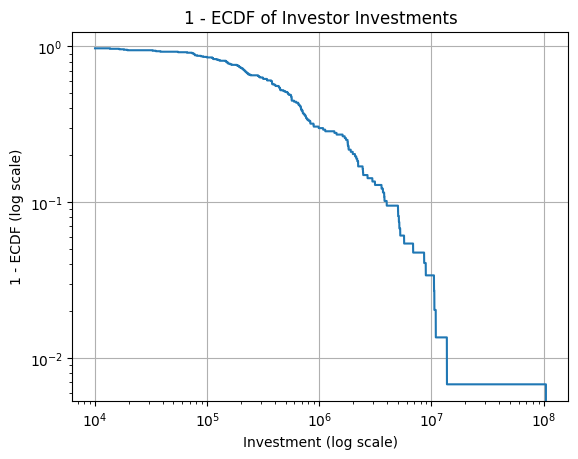

In [45]:


# Calculate the 1-ECDF for the investments

ecdf=ECDF(M.iloc[:,1])
plt.plot(np.linspace(1e4,max(M.iloc[:,1]),10000000),1-ecdf(np.linspace(1e4,max(M.iloc[:,1]),10000000)))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Investment (log scale)')
plt.ylabel('1 - ECDF (log scale)')
plt.title('1 - ECDF of Investor Investments')
plt.grid(True)
plt.show()




Text(0.5, 1.0, 'Densité de probabilité estimée par noyau')

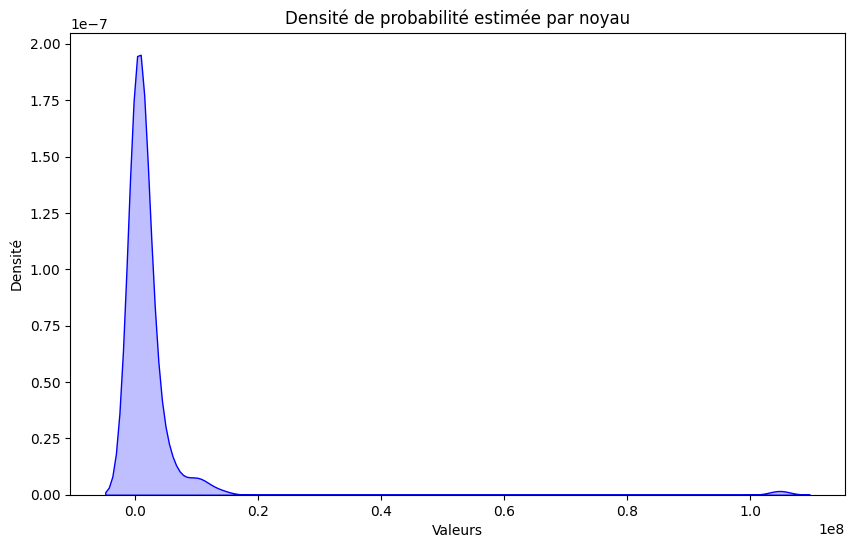

In [61]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.kdeplot(M.iloc[:,1], fill=True, color='blue', bw_adjust=0.5)

# Ajouter des labels et un titre
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.title('Densité de probabilité estimée par noyau')

In [46]:
import powerlaw

In [47]:
fit =powerlaw.Fit(1-ecdf(np.linspace(1e4,max(M.iloc[:,1]))))
print(fit.power_law.alpha)
print(fit.power_law.xmin)

Calculating best minimal value for power law fit
3.925160491748701%
0.006802721088435382


Values less than or equal to 0 in data. Throwing out 0 or negative values


In [65]:
# Calculer le rendement quotidien
prices_data=pd.read_csv('BBVA_Prices.csv')
prices_data['return'] = np.log(prices_data['close'].pct_change()+1)
investors_data=investors

# Joindre les données des investisseurs avec les rendements quotidiens
investors_data = investors_data.merge(prices_data[['date', 'return']], on='date', how='left')

# Calculer le changement d'inventaire pour chaque investisseur
investors_data['inventory_change'] = investors_data.groupby('investor_id')['position'].diff()

# Supprimer les lignes avec des valeurs manquantes
investors_data = investors_data.dropna()

# Calculer la corrélation pour chaque investisseur
investor_correlation = investors_data.groupby('investor_id').apply(lambda x: x['inventory_change'].corr(x['return']))

# Classer les investisseurs
def classify_investor(correlation):
    if correlation > 0:
        return 'trend-following'
    elif correlation < 0:
        return 'contrarian'
    else:
        return 'neutral'

investor_classification = investor_correlation.apply(classify_investor)

# Afficher la classification
investor_classification

C:\Users\Périg\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Périg\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


investor_id
704           contrarian
744           contrarian
1312          contrarian
2236          contrarian
2300          contrarian
              ...       
18397            neutral
18401         contrarian
18404    trend-following
18416         contrarian
18427    trend-following
Length: 147, dtype: object

(-0.5, 0.5)

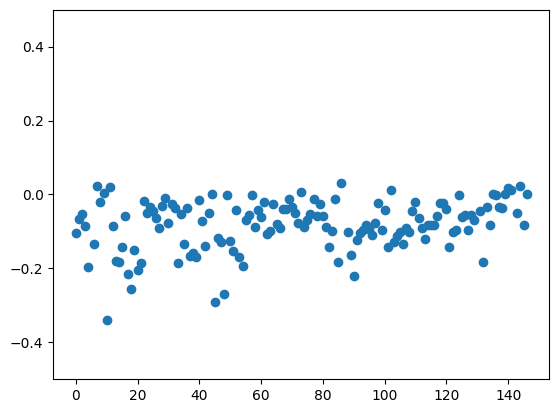

In [66]:
plt.scatter(np.arange(len(investor_correlation)),investor_correlation)
plt.ylim(-0.5, 0.5)

In [62]:
mid_date = investors_data['date'].iloc[len(investors_data) // 2]
period1 = investors_data[investors_data['date'] <= mid_date]
period2 = investors_data[investors_data['date'] > mid_date]

# Fonction pour classifier les investisseurs
def classify_investors(data):
    investor_correlation = data.groupby('investor_id').apply(lambda x: x['inventory_change'].corr(x['return']))
    return investor_correlation.apply(lambda x: 'trend-following' if x > 0 else ('contrarian' if x < 0 else 'neutral'))

# Classer les investisseurs pour chaque période
classification_period1 = classify_investors(period1)
classification_period2 = classify_investors(period2)

# Combiner les classifications des deux périodes
combined_classification = pd.DataFrame({
    'period1': classification_period1,
    'period2': classification_period2
}).dropna()

# Calculer la table de transition
transition_counts = pd.crosstab(combined_classification['period1'], combined_classification['period2'])
transition_probabilities = transition_counts.div(transition_counts.sum(axis=1), axis=0)

# Afficher la table de transition
print("Transition Counts:")
print(transition_counts)
print("\nTransition Probabilities:")
print(transition_probabilities)

C:\Users\Périg\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Périg\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Transition Counts:
period2          contrarian  neutral  trend-following
period1                                              
contrarian               67       35                4
neutral                  21        4                5
trend-following           4        5                2

Transition Probabilities:
period2          contrarian   neutral  trend-following
period1                                               
contrarian         0.632075  0.330189         0.037736
neutral            0.700000  0.133333         0.166667
trend-following    0.363636  0.454545         0.181818


In [63]:




# Fonction pour classifier les investisseurs
def classify_investors(data):
    investor_correlation = data.groupby('investor_id').apply(lambda x: x['inventory_change'].corr(x['next_day_return']))
    return investor_correlation.apply(lambda x: 'trend-following' if x > 0 else ('contrarian' if x < 0 else 'neutral'))

# Classer les investisseurs pour l'ensemble de la période
classification_all = classify_investors(investors_data)

# Diviser les données en deux périodes de longueur égale
mid_date = investors_data['date'].iloc[len(investors_data) // 2]
period1 = investors_data[investors_data['date'] <= mid_date]
period2 = investors_data[investors_data['date'] > mid_date]

# Classer les investisseurs pour chaque période
classification_period1 = classify_investors(period1)
classification_period2 = classify_investors(period2)

# Combiner les classifications des deux périodes
combined_classification = pd.DataFrame({
    'period1': classification_period1,
    'period2': classification_period2
}).dropna()

# Calculer la table de transition
transition_counts = pd.crosstab(combined_classification['period1'], combined_classification['period2'])
transition_probabilities = transition_counts.div(transition_counts.sum(axis=1), axis=0)

# Afficher les résultats
print("Transition Counts:")
print(transition_counts)
print("\nTransition Probabilities:")
print(transition_probabilities)

KeyError: 'next_day_return'